In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
import time

In [2]:
wine_path = "data/winequality-white.csv"
wineq_np = np.loadtxt(wine_path,dtype=np.float32,delimiter=";",skiprows=1)
wineq = torch.tensor(wineq_np)

In [3]:
t_u = wineq[:,:-1]
t_c = wineq[:,-1]
t_c = torch.tensor(t_c).unsqueeze(1)

n_inputs = t_u.shape[1]
n_outputs = t_c.shape[1]

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

C:\Users\joshu\AppData\Local\Temp\ipykernel_14740\4024535812.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_c = torch.tensor(t_c).unsqueeze(1)


In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]


In [5]:
t_un_train = t_u_train
t_un_val = t_u_val


for feature in range(n_inputs):
    t_un_train[:,feature] = t_u_train[:,feature]/torch.max(t_u_train[:,feature])
    t_un_val[:,feature] = t_u_val[:,feature]/torch.max(t_u_val[:,feature])

In [6]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    losses_train = torch.zeros(n_epochs)
    losses_val = torch.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)
        losses_train[epoch-1] = loss_train

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        losses_val[epoch-1] = loss_val
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
    return losses_val,losses_train

In [7]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(n_inputs, 500)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(500, n_outputs))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=11, out_features=500, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=500, out_features=1, bias=True)
)

In [8]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>
start_time = time.time()
losses_train, losses_val = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
elapsed_time = time.time() - start_time
print(f"elapsed time: {np.round(elapsed_time)} seconds")

Epoch 1, Training loss 36.2949, Validation loss 36.1597
Epoch 1000, Training loss 0.7006, Validation loss 0.6842
Epoch 2000, Training loss 0.6627, Validation loss 0.6333
Epoch 3000, Training loss 0.6393, Validation loss 0.6215
Epoch 4000, Training loss 0.6236, Validation loss 0.6202
Epoch 5000, Training loss 0.6124, Validation loss 0.6200
elapsed time: 64.0 seconds


Die Trainingsdauer lässt sich über dieser Zelle ablesen. 

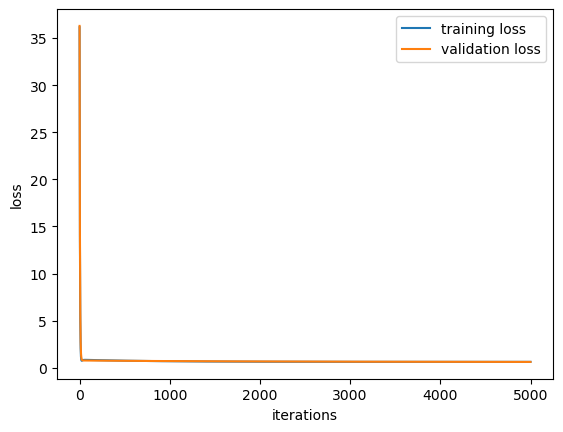

In [9]:
plt.plot(losses_train.detach().numpy())
plt.plot(losses_val.detach().numpy())
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(['training loss','validation loss'])
plt.show()

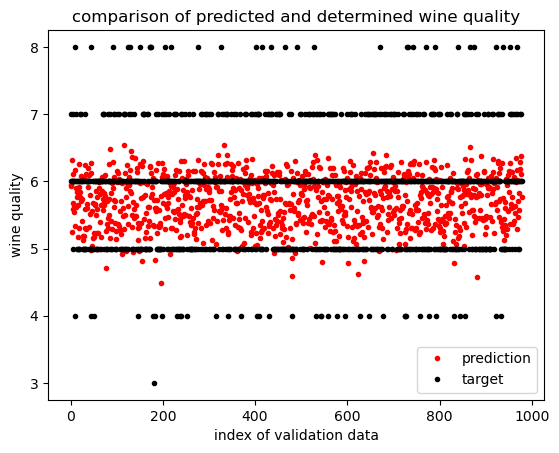

In [10]:
results =  seq_model(t_u_val)

prediction = results[:,0].detach().numpy()
target = t_c_val[:,0].detach().numpy()

plt.plot(prediction,'r.')
plt.plot(target,'k.')
plt.xlabel('index of validation data')
plt.ylabel('wine quality')
plt.legend(['prediction','target'])
plt.title('comparison of predicted and determined wine quality')
plt.show()


In dem oberen Plot sind die vorhergesagten Geschmacksqualitäten auf Grundlage der chemischen Eigenschaften zusammen mit den bestimmten Qualitätsindex abgebildet.

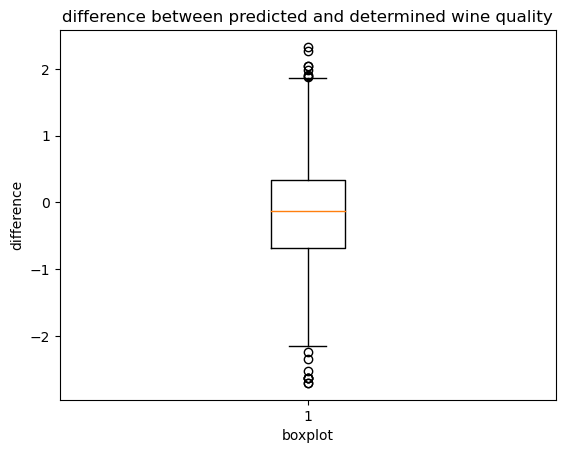

In [11]:
plt.boxplot(prediction-target)
plt.title('difference between predicted and determined wine quality')
plt.xlabel('boxplot')
plt.ylabel('difference')
plt.show()

In dem oberen Boxplot ist die Differenz der vorhergesagten und der bestimmten Weinqualität abgebildet um so die Abweichung zu verdeutlichen.